**VGG**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.run_functions_eagerly(True)  # Enable eager execution

# Unzip the dataset (FIXED: quote the zip path)
!unzip -qq "/content/OnlyNew (2).zip" -d "/content/brain_tumor_dataset"

# Load the dataset
data = keras.utils.image_dataset_from_directory("/content/brain_tumor_dataset")


Found 3000 files belonging to 1 classes.


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [3]:
tf.config.run_functions_eagerly(True) # Enable eager execution

In [9]:
data = keras.utils.image_dataset_from_directory(
    "/content/brain_tumor_dataset/OnlyNew/New_braintumor"
)


Found 3000 files belonging to 2 classes.


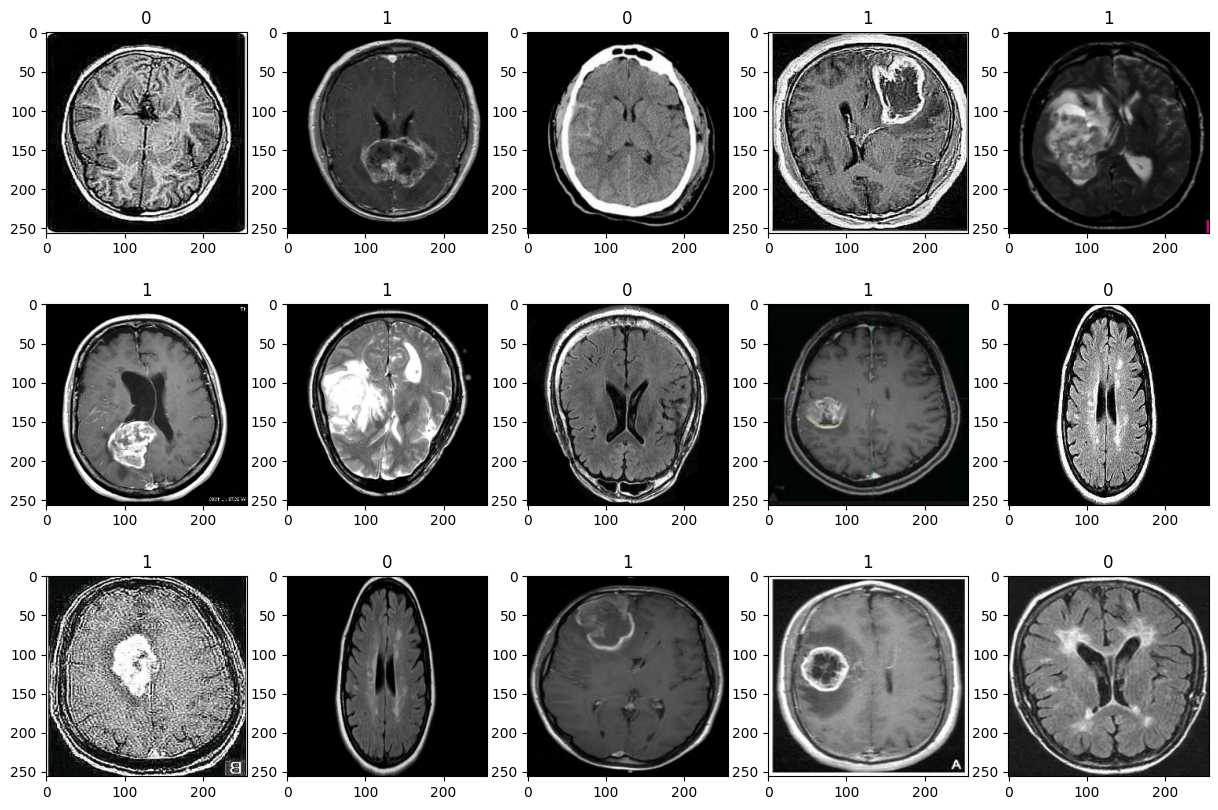

In [10]:
# Display sample images from the dataset
batch = data.as_numpy_iterator().next()
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

# -----------------------------
# IMPORTANT: VGG uses preprocess_input
# So REMOVE x/255 normalization
# -----------------------------
train = train.map(lambda x, y: (preprocess_input(x), y))
val   = val.map(lambda x, y: (preprocess_input(x), y))
test  = test.map(lambda x, y: (preprocess_input(x), y))

# -----------------------------
# Basic VGG19 Backbone
# -----------------------------
base_model = VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze VGG layers (baseline)
base_model.trainable = False

# -----------------------------
# Simple VGG Classifier Head
# -----------------------------
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

# -----------------------------
# Compile
# -----------------------------
model.compile(
    optimizer="adam",
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    train,
    validation_data=val,
    epochs=30,
    verbose=1
)

# -----------------------------
# Evaluate
# -----------------------------
train_loss, train_acc = model.evaluate(train, verbose=0)
val_loss, val_acc     = model.evaluate(val, verbose=0)
test_loss, test_acc   = model.evaluate(test, verbose=0)

print("\n📊 VGG19 Results")
print(f"Train Acc: {train_acc:.4f}")
print(f"Val   Acc: {val_acc:.4f}")
print(f"Test  Acc: {test_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5091 - loss: 0.9718 - val_accuracy: 0.6678 - val_loss: 0.6570
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 1000ms/step - accuracy: 0.5482 - loss: 0.7186 - val_accuracy: 0.7007 - val_loss: 0.6408
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 990ms/step - accuracy: 0.6372 - loss: 0.6438 - val_accuracy: 0.6414 - val_loss: 0.6205
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6553 - loss: 0.6281 - val_accuracy: 0.6859 - val_loss: 0.6245
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 996ms/step - accuracy: 0.6746 - loss: 0.6033 - val_accuracy: 0.6990 - val_loss: 0.6138
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6817 - loss: 0.5998 - val_accuracy: 0.6793 - val_loss: 0.6029
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 996ms/step - accuracy: 0.6536 - loss: 0.6138 - val_accuracy: 0.6711 - val_loss: 0.6085
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 998ms/step -

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


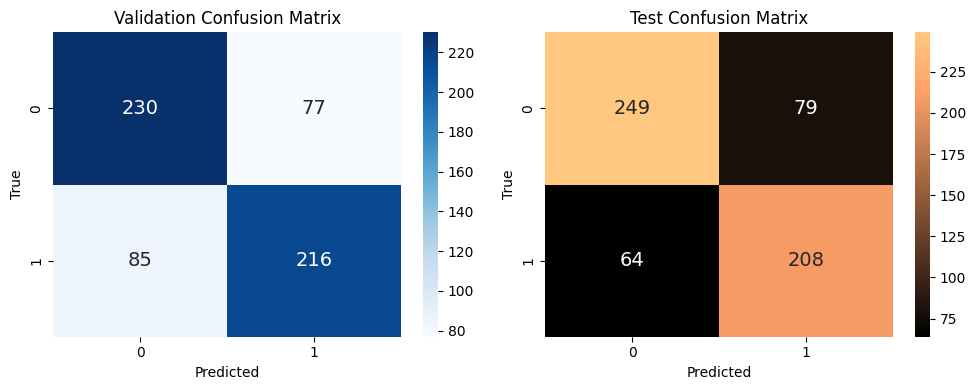

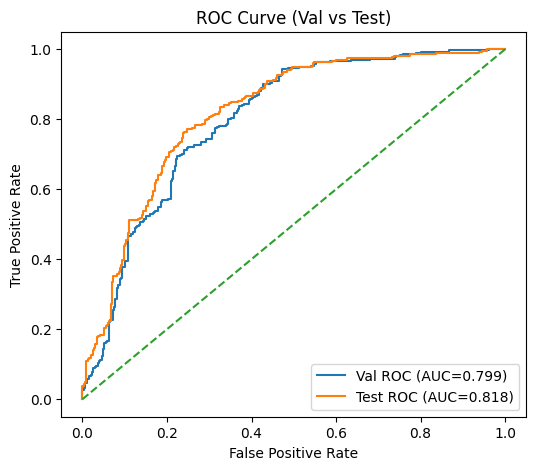

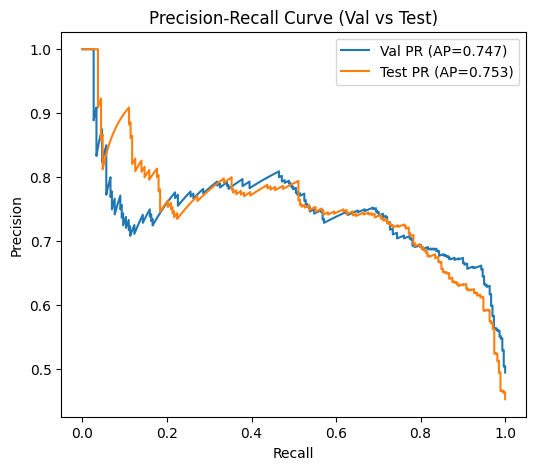

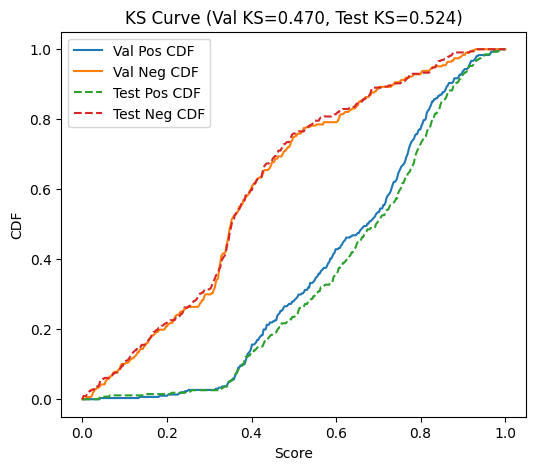

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# ---------- helpers ----------
def get_probs_and_labels(model, ds):
    y_true_list, y_prob_list = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0).reshape(-1)
        y_true_list.append(y.numpy().reshape(-1))
        y_prob_list.append(p)
    y_true = np.concatenate(y_true_list)
    y_prob = np.concatenate(y_prob_list)
    y_pred = (y_prob >= 0.5).astype(int)
    return y_true, y_prob, y_pred

def ks_stat(y_true, y_prob, n_grid=400):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob)
    pos = y_prob[y_true == 1]
    neg = y_prob[y_true == 0]
    if len(pos) == 0 or len(neg) == 0:
        return np.nan, None, None, None
    grid = np.linspace(0, 1, n_grid)
    cdf_pos = np.array([(pos <= g).mean() for g in grid])
    cdf_neg = np.array([(neg <= g).mean() for g in grid])
    diff = np.abs(cdf_pos - cdf_neg)
    ks = float(diff.max())
    return ks, grid, cdf_pos, cdf_neg

def plot_confusion_matrices(yv_true, yv_pred, yt_true, yt_pred):
    cm_val = confusion_matrix(yv_true, yv_pred)
    cm_test = confusion_matrix(yt_true, yt_pred)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Validation (blue) with fmt="d"
    sns.heatmap(
        cm_val, annot=True, fmt="g", cmap="Blues",
        ax=ax[0], cbar=True, annot_kws={"size": 14}
    )
    ax[0].set_title("Validation Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("True")

    # Test (brown) with fmt="d"
    sns.heatmap(
        cm_test, annot=True, fmt="d", cmap="copper",
        ax=ax[1], cbar=True, annot_kws={"size": 14}
    )
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

def plot_roc_pr_ks(yv_true, yv_prob, yt_true, yt_prob):
    # ROC
    fpr_v, tpr_v, _ = roc_curve(yv_true, yv_prob)
    fpr_t, tpr_t, _ = roc_curve(yt_true, yt_prob)
    auc_v = roc_auc_score(yv_true, yv_prob)
    auc_t = roc_auc_score(yt_true, yt_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={auc_v:.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={auc_t:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Val vs Test)")
    plt.legend()
    plt.show()

    # PR
    prec_v, rec_v, _ = precision_recall_curve(yv_true, yv_prob)
    prec_t, rec_t, _ = precision_recall_curve(yt_true, yt_prob)
    ap_v = average_precision_score(yv_true, yv_prob)
    ap_t = average_precision_score(yt_true, yt_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(rec_v, prec_v, label=f"Val PR (AP={ap_v:.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AP={ap_t:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Val vs Test)")
    plt.legend()
    plt.show()

    # KS
    ks_v, grid_v, cdfp_v, cdfn_v = ks_stat(yv_true, yv_prob)
    ks_t, grid_t, cdfp_t, cdfn_t = ks_stat(yt_true, yt_prob)

    plt.figure(figsize=(6, 5))
    if grid_v is not None:
        plt.plot(grid_v, cdfp_v, label="Val Pos CDF")
        plt.plot(grid_v, cdfn_v, label="Val Neg CDF")
    if grid_t is not None:
        plt.plot(grid_t, cdfp_t, linestyle="--", label="Test Pos CDF")
        plt.plot(grid_t, cdfn_t, linestyle="--", label="Test Neg CDF")
    plt.xlabel("Score")
    plt.ylabel("CDF")
    plt.title(f"KS Curve (Val KS={ks_v:.3f}, Test KS={ks_t:.3f})")
    plt.legend()
    plt.show()

# ---------- run on your trained VGG model ----------
yv_true, yv_prob, yv_pred = get_probs_and_labels(model, val)
yt_true, yt_prob, yt_pred = get_probs_and_labels(model, test)

plot_confusion_matrices(yv_true, yv_pred, yt_true, yt_pred)
plot_roc_pr_ks(yv_true, yv_prob, yt_true, yt_prob)


In [29]:
import os, time
import numpy as np
import pandas as pd
import tensorflow as tf

# =========================
# 1) SAVE MODEL
# =========================
SAVE_DIR = "/content/vgg19_brain_tumor_model"

# (A) Recommended: SavedModel folder
model.save("/content/vgg19_brain_tumor_model.keras")
print("Keras file saved at:", SAVE_DIR + ".keras")


# =========================
# 2) TRAINING TIME (if you didn’t capture it already)
# =========================
# Wrap your fit like this when training:
# t0 = time.perf_counter()
# history = model.fit(train, validation_data=val, epochs=30, verbose=1)
# train_time_sec = time.perf_counter() - t0

# If you already trained and didn't measure, you must re-train to get true training time.


# =========================
# 3) INFERENCE TIME (ms/image)
# =========================
def inference_ms_per_image(model, ds, warmup=2, steps=5):
    it = iter(ds)
    x, _ = next(it)

    # warmup
    for _ in range(warmup):
        _ = model(x, training=False)

    t0 = time.perf_counter()
    for _ in range(steps):
        _ = model(x, training=False)
    t1 = time.perf_counter()

    total_imgs = x.shape[0] * steps
    return (t1 - t0) * 1000.0 / total_imgs

inf_ms = inference_ms_per_image(model, test, warmup=2, steps=10)
print(f"Inference time: {inf_ms:.3f} ms/image")


# =========================
# 4) PARAMS + GFLOPs TABLE
# =========================
def trainable_params(model):
    return int(np.sum([np.prod(v.shape) for v in model.trainable_variables]))

def get_gflops(model, input_shape=(1, 256, 256, 3)):
    # Best-effort; may return NaN on some TF builds
    try:
        fn = tf.function(model).get_concrete_function(tf.TensorSpec(input_shape, tf.float32))
        frozen = tf.graph_util.convert_variables_to_constants_v2(fn)
        graph_def = frozen.graph.as_graph_def()

        with tf.Graph().as_default() as g:
            tf.graph_util.import_graph_def(graph_def, name="")
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd="op", options=opts)

        return (flops.total_float_ops / 1e9) if flops is not None else np.nan
    except Exception:
        return np.nan

gflops = get_gflops(model, input_shape=(1, 256, 256, 3))

# If you measured train_time_sec during fit, include it; otherwise set NaN
train_time_sec = globals().get("train_time_sec", np.nan)

compute_df = pd.DataFrame([{
    "Model": model.name,
    "Training time (s)": float(train_time_sec) if train_time_sec == train_time_sec else np.nan,
    "Inference time (ms/image)": float(inf_ms),
    "Trainable Params": trainable_params(model),
    "Total Params": int(model.count_params()),
    "GFLOPs (approx)": float(gflops),
}])

compute_df


Keras file saved at: /content/vgg19_brain_tumor_model.keras
Inference time: 4.009 ms/image


,Model,Training time (s),Inference time (ms/image),Trainable Params,Total Params,GFLOPs (approx)
0,sequential_2,NaN,4.009252,65793,20090177,NaN


In [31]:
import time

t0 = time.perf_counter()
history = model.fit(train, validation_data=val, epochs=30, verbose=1)
train_time_sec = time.perf_counter() - t0

print("Training time (s):", train_time_sec)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 973ms/step - accuracy: 0.7214 - loss: 0.5482 - val_accuracy: 0.6974 - val_loss: 0.5813
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 996ms/step - accuracy: 0.6987 - loss: 0.5555 - val_accuracy: 0.7500 - val_loss: 0.5285
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 995ms/step - accuracy: 0.7179 - loss: 0.5517 - val_accuracy: 0.7352 - val_loss: 0.5498
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 993ms/step - accuracy: 0.7275 - loss: 0.5518 - val_accuracy: 0.7220 - val_loss: 0.5482
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7190 - loss: 0.5344 - val_accuracy: 0.7286 - val_loss: 0.5557
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7228 - loss: 0.5471 - val_accuracy: 0.7319 - val_loss: 0.5581
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 982ms/step - accuracy: 0.7143 - loss: 0.5520 - val_accuracy: 0.7582 - val_loss: 0.5295
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 981ms/step - accuracy: 0.7255 - loss: 0.5514 - val_accuracy: 